# Applying selection criteria on measurements with uncertainties

* tldr; measurement uncerainty should be taken into account when applying a selection criterion to be maximally conservative i.e. allow subsamples with uncertainties to be considered which would otherwise be strictly ignored and conversely ignore measurements with large uncertainties to be discarded

In [1]:
%matplotlib inline
from scipy import stats
import numpy as np
import matplotlib.pyplot as pl
from astropy.visualization import hist
import warnings
warnings.simplefilter("ignore")    
pl.style.use('fivethirtyeight')

## Concepts

To select a sub-sample from the population, a selection criteria is used. Usually, the selection criteria is a set of inequalities applied to specific properties of the population. 

Given a parameter of the population, x:
* x>a (a is the lower limit)
* x<b (b is the upper limit)

Combining inqualities is done using boolean logic, e.g.
* a<x<b : (x>a) & (x<b)

## Create mock measurements

Now we simulate measurements within some bounds $A$, $B$. Assuming the mean measurements are uniformly distributed:

In [3]:
bounds = (0, 13)
nsamples = int(1e4)

#data uniformaly distributed within measurement bounds
data_mean = stats.uniform.rvs(bounds[0], bounds[1], size=nsamples)

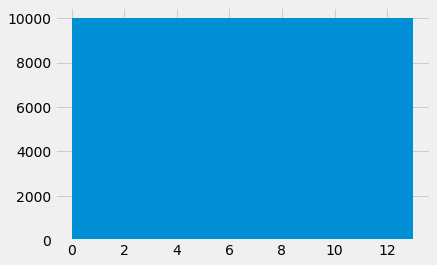

In [4]:
hist(data_mean, bins='knuth');

Naively, we would immediately do the following

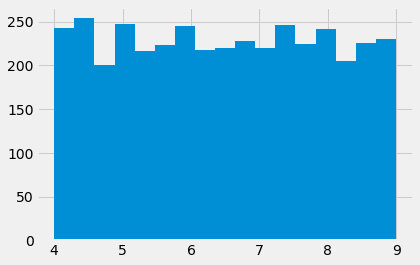

In [5]:
idx = (data_mean>4) & (data_mean<9)
hist(data_mean[idx], bins='knuth');

However, in reality, no measurement is exact and always have uncertainties.

If each mean measurement above has associated uncertainty (drawn from a normal distribution), then

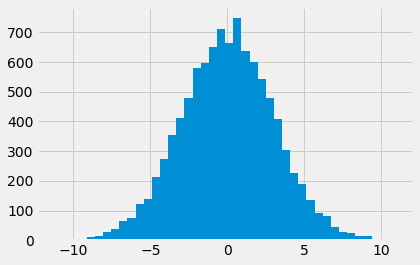

In [6]:
#data uncertainty centered on mean and arbitrary width
data_unc = stats.norm.rvs(0, 3, size=nsamples)

hist(data_unc, bins='knuth');

How do we apply our criteria to select a subsample taking into account measurement uncertainties?

## Normal distribution

Assuming the parameter is drawn from a standard normal distribution (mean=0, sigma=1)

Text(0.5, 0, 'x')

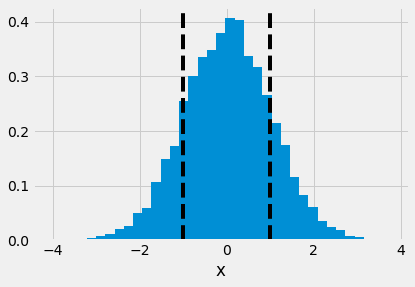

In [7]:
loc, scale = 0, 1 #standard normal
nsamples = int(1e4)
samples = stats.norm.rvs(loc, scale, nsamples)
_ = hist(samples, bins='knuth', density=True);
pl.axvline(-scale, 0, 1, ls='--', c='k')
pl.axvline(scale, 0, 1, ls='--', c='k')
pl.xlabel('x')

## cumulative distribution function

CDF allows us to compute the probability of drawing a value $x_i$ from the distribution $x$

For example, the probabilities

In [8]:
stats.norm.cdf([-1,0,1], loc=loc, scale=scale)

array([0.15865525, 0.5       , 0.84134475])

16-50-84 rule

Text(0, 0.5, 'CDF')

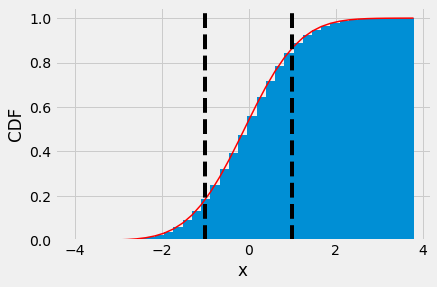

In [9]:
n, bins, _ = hist(samples, bins='knuth', density=True, cumulative=True);
# Add a line showing the expected distribution.
y = ((1 / (np.sqrt(2 * np.pi) * scale)) *
     np.exp(-0.5 * (1 / scale * (bins - loc))**2))
y = y.cumsum()
y /= y[-1]
pl.plot(bins, y, 'r-', linewidth=1.5, label='Theoretical')

pl.axvline(-scale, 0, 1, ls='--', c='k')
pl.axvline(scale, 0, 1, ls='--', c='k')
pl.xlabel('x')
pl.ylabel('CDF')

## applying criteria

Suppose we want to select only those measurements (with uncertainties) that fall within an interval $a$, $b$.

In [10]:
#define criteria
lower, upper = 4, 9

Then we evaluate the cdf of each limit as if it is drawn from the distribution with $N$($x_i,\sigma_i$). To get the subsample above $a$, then the cdf($a$)|$_{N(x_i,\sigma_i)}$ < cdf($\sigma$)|$_{N(0,1)}$.

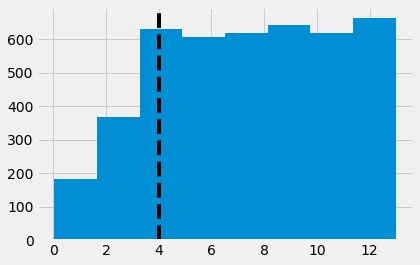

In [11]:
sigma = 1
idx1 = stats.norm.cdf(lower, loc=data_mean, scale=data_unc) < stats.norm.cdf(sigma, loc=0, scale=1)
hist(data_mean[idx1], bins='knuth');
pl.axvline(lower, 0, 1, ls='--', c='k')

Whereas to get the subsample below $b$, then the cdf($b$)|$_{N(x_i,\sigma_i)}$ > cdf($-\sigma$)|$_{N(0,1)}$.

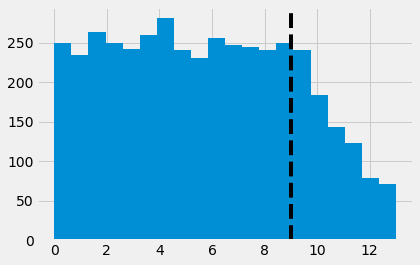

In [12]:
idx2 = stats.norm.cdf(upper, loc=data_mean, scale=data_unc) > stats.norm.cdf(-sigma, loc=0, scale=1)
hist(data_mean[idx2], bins='knuth');
pl.axvline(upper, 0, 1, ls='--', c='k')

Combining each is simply

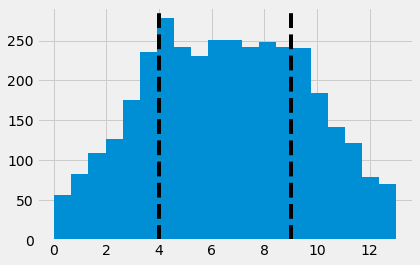

In [13]:
hist(data_mean[idx1 & idx2], bins='knuth');
pl.axvline(lower, 0, 1, ls='--', c='k')
pl.axvline(upper, 0, 1, ls='--', c='k')

In the plot above, we see mean measurements slightly outside the limits when uncertainties are taken into account. 

## changing sigma

Changing sigma means loosensing or tightening our constraints when applying the cut.

In [14]:
def plot_cdf(sigma=1, nsamples=int(1e4)):
    x = np.linspace(-2, 2, nsamples)
    y = stats.norm.cdf(x,scale=sigma)
    pl.plot(x, y, ls='-',label=f'sigma={sigma}')

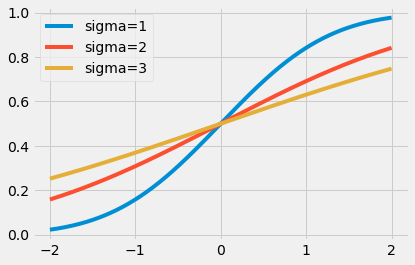

In [15]:
plot_cdf(sigma=1)
plot_cdf(sigma=2)
plot_cdf(sigma=3)
pl.legend()

First let's write the routine above as functions

In [16]:
from scipy.stats import norm

def get_above_lower_limit(lower, data_loc, data_unc, sigma=1):
    idx = (
        norm.cdf(lower, data_loc, data_unc) < norm.cdf(sigma)
        )
    return idx

def get_below_upper_limit(upper, data_loc, data_unc, sigma=1):
    idx = (
        norm.cdf(upper, data_loc, data_unc) > norm.cdf(-sigma)
        )
    return idx

def get_between_limits(lower, upper, data_loc, data_unc, sigma=1):
    idx = (
        get_below_upper_limit(upper, data_loc, data_unc, sigma=sigma) &
        get_above_lower_limit(lower, data_loc, data_unc, sigma=sigma)
        )
    return idx

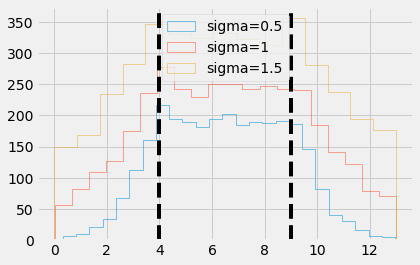

In [17]:
for sigma in [0.5,1,1.5]:
    idx = get_between_limits(lower, upper, data_mean, data_unc, sigma=sigma)
    hist(data_mean[idx], bins='knuth', histtype='step', label=f'sigma={sigma}');
pl.axvline(lower, 0, 1, ls='--', c='k')
pl.axvline(upper, 0, 1, ls='--', c='k')
pl.legend();

I hope I gave you a more rigorous way to apply statistics when applying a simple criteria given measurements with uncertainties.

The fact that `scipy` implements vectorized boolean logic makes this exerise a breeze.